(supervised:linear-regression:regularization)=
# Regularization

Whenever we try to fit a model to a finite data set we have to find a compromise between two competing aims:
* Fit the data as good as possible.
* Generalize information from data to regions in feature space without data (fit the truth).

One problem is that data usually contains noise and thus does not contain arbitrarily precise information about the underlying truth. On the other hand, in most applications there is not the one underlying truth. If some relevant features are not contained in the data set, then even a complete data set does not allow to recover underlying truth.

An example for the second issue is prediction of prices, say house prices. The price depends on many features, which cannot be recorded completely. Thus, corresponding data set might contain a feature vector twice, but with different target values (prices). Which is the better one, that is, which one contains more truth?

Fitting data as good as possible is quite easy. The hard part is to avoid *overfitting*. By overfitting we mean neglecting the second aim. That is, our hypothesis fits the data very well, but does not represent essential properties of the underlying truth.

## Example

Let's have a look at an illustrating example. We consider data with only one feature, so we can plot everything and visualize the problem.

First some standard imports and initialization of the random number generator.

In [1]:
import numpy as np
import matplotlib.pyplot as plt

import sklearn.linear_model as lm
from sklearn.preprocessing import PolynomialFeatures

from numpy.random import default_rng
rng = default_rng(0)

To investigate overfitting we choose an underlying truth and simulate data based on this truth. This way we have access to the in practice unknown truth and can compare predictions to the truth.

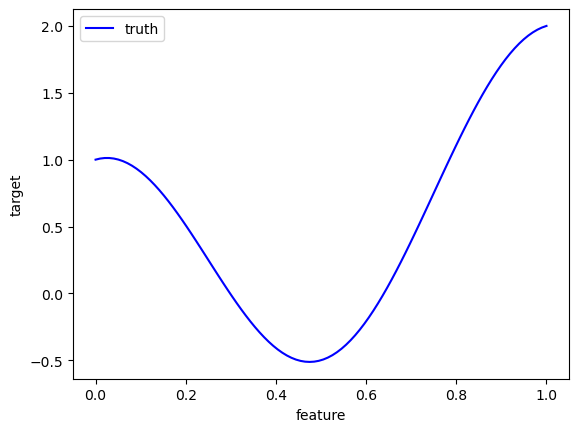

In [4]:
# function to reconstruct from data ('underlying truth')
def truth(x):
    return x + np.cos(2 * np.pi * x)

# range and grid for plotting
xmin = 0
xmax = 1
x = np.linspace(xmin, xmax, 100)

# plot truth
fig, ax = plt.subplots()
ax.plot(x, truth(x), '-b', label='truth')
ax.legend()
ax.set_xlabel('feature')
ax.set_ylabel('target')
plt.show()

To simulate data we generate uniformly distributed arguments, calculate corresponding true function values, and add some noise. Noise almost always follows a normal distribution.

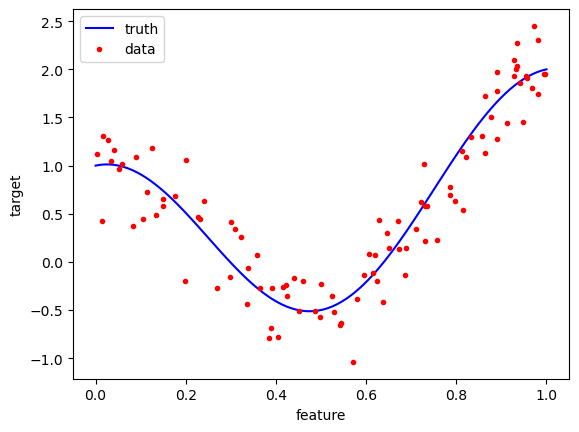

In [5]:
n = 100    # number of data points to generate
noise_level = 0.3    # standard deviation of artificial noise

# simulate data
X = (xmax - xmin) * rng.random((n, 1)) + xmin
y = truth(X).reshape(-1) + noise_level * rng.standard_normal(n)

# plot truth and data
fig, ax = plt.subplots()
ax.plot(x, truth(x), '-b', label='truth')
ax.plot(X.reshape(-1), y, 'or', markersize=3, label='data')
ax.set_xlabel('feature')
ax.set_ylabel('target')
ax.legend()
plt.show()

We use polynomial regression for obtaining a model explaining our data. Different degrees of the polynomial will yield very different results (try 1, 2, 5, 10, 15, 20, 25).

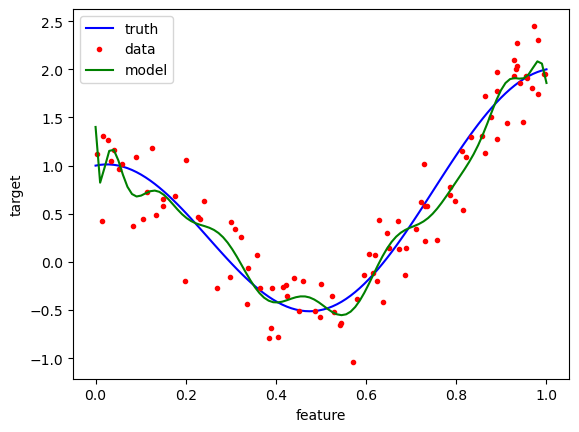

In [8]:
degree = 20    # degree for polynomial regression

# regression
regression = lm.LinearRegression()
transform = PolynomialFeatures(degree=degree).fit_transform
regression.fit(transform(X), y)

# get hypothesis for plotting
y_reg = regression.predict(transform(x.reshape(-1, 1)))

# plot truth, data, hypothesis
fig, ax = plt.subplots()
ax.plot(x, truth(x), '-b', label='truth')
ax.plot(X.reshape(-1), y, 'or', markersize=3, label='data')
ax.plot(x, y_reg, '-g', label='model')
ax.set_xlabel('feature')
ax.set_ylabel('target')
ax.legend()
plt.show()

Obviously, there is an optimal degree, say 4 or 5 or 6. The degree in polynomial regression is a hyperparameter.

For lower degrees our model is not versatile enough to grasp the truth's structure. For higher degrees we observe overfitting: the model adapts very well to the data points, but tends to oscillate to reach as many data points as possible. These oscillations are an artifact and not a characteristic of the underlying truth.

Before we discuss how to avoid overfitting, we have to think about a different issue: How to detect overfitting? In our illustrating example we know the underlying truth and can compare the hypothesis to the truth. But in practice we do not know the truth!

## Detecting overfitting

We split our data set into two subsets: one for fitting the model (training set) and one for detecting overfitting (validation set). If our model is close to the (unknown) truth, then the error on both subsets should be almost identical. In case of overfitting the error on the training set will be much smaller than on the validation set.

Here, the error is the *mean squared error*:
\begin{equation*}
\frac{1}{n}\,\sum_{k=1}^n\bigl(f_{\mathrm{approx}}(x_k)-y_k\bigr)^2,
\end{equation*}
where $(x_1,y_1),\ldots,(x_n,y_n)$ are the samples from the considered subset.

Let's test this with the above example. First we split the data set.

(50, 1) (50, 1)


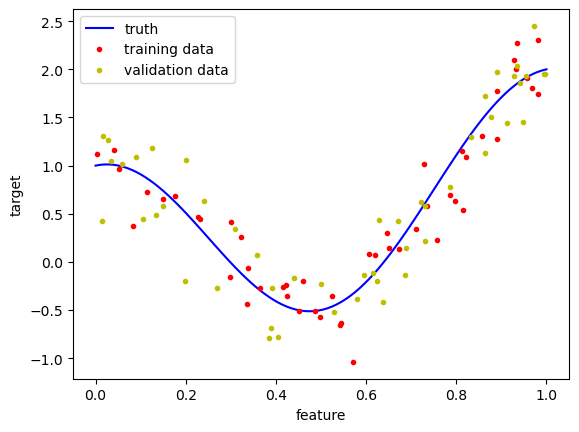

In [9]:
from sklearn.model_selection import train_test_split

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.5)

print(X_train.shape, X_val.shape)

# plot truth, training data, validation data
fig, ax = plt.subplots()
ax.plot(x, truth(x), '-b', label='truth')
ax.plot(X_train.reshape(-1), y_train, 'or', markersize=3, label='training data')
ax.plot(X_val.reshape(-1), y_val, 'oy', markersize=3, label='validation data')
ax.set_xlabel('feature')
ax.set_ylabel('target')
ax.legend()
plt.show()

Now we fit models for different degrees and plot corresponding errors on the training set and on the validation set.

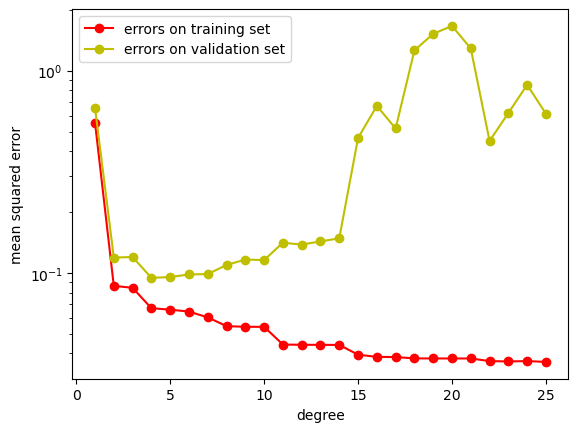

   training    validation
[[0.55327756 0.65483872]
 [0.08634214 0.119108  ]
 [0.08442359 0.11991263]
 [0.06694953 0.09463578]
 [0.06584899 0.09539557]
 [0.06440824 0.09831239]
 [0.06030987 0.09869475]
 [0.05459956 0.10948717]
 [0.05416856 0.11645479]
 [0.05416567 0.11578297]
 [0.04427975 0.14101537]
 [0.04413737 0.13811564]
 [0.04411521 0.1431831 ]
 [0.04407453 0.14827712]
 [0.03944999 0.46436207]
 [0.03846396 0.66928752]
 [0.03839572 0.51795306]
 [0.0378066  1.25822297]
 [0.03778724 1.5208766 ]
 [0.03778158 1.66348658]
 [0.03777532 1.28780466]
 [0.03667487 0.44913459]
 [0.03650158 0.61691911]
 [0.03667436 0.85090129]
 [0.03632425 0.61247783]]


In [10]:
from sklearn import metrics

max_degree = 25

regression = lm.LinearRegression()

train_errors = np.zeros(max_degree)
val_errors = np.zeros(max_degree)

degrees = range(1, max_degree + 1)

for degree in degrees:

    # regression
    transform = PolynomialFeatures(degree=degree).fit_transform
    regression.fit(transform(X_train), y_train)

    # predictions on subsets
    y_train_pred = regression.predict(transform(X_train))
    y_val_pred = regression.predict(transform(X_val))
    
    # errors
    train_errors[degree - 1] = metrics.mean_squared_error(y_train_pred, y_train)
    val_errors[degree - 1] = metrics.mean_squared_error(y_val_pred, y_val)

# plot errors
fig, ax = plt.subplots()
ax.semilogy(degrees, train_errors, '-or', label='errors on training set')
ax.semilogy(degrees, val_errors, '-oy', label='errors on validation set')
ax.set_xlabel('degree')
ax.set_ylabel('mean squared error')
ax.legend()
plt.show()

# print errors
print('   training    validation')
print(np.stack((train_errors, val_errors), axis=1))

The higher the degree, the smaller the error on the training set, but the higher the error on the validation set. Starting at degree about 15 the difference between both errors grows significantly. This shows that the small error on the training set is not a result of a well approximated truth, but stems from overfitting.

Here we also see that the error on the validation set is slightly larger than on the training set, because the hypothesis has been fitted to the training data.

## Avoiding Overfitting

Overfitting almost always correlates with very large parameters after fitting the model. Thus, penalizing parameter values should be a good idea.

Let's have a look at the parameters in our illustrative example for both cases good fit and overfitting.

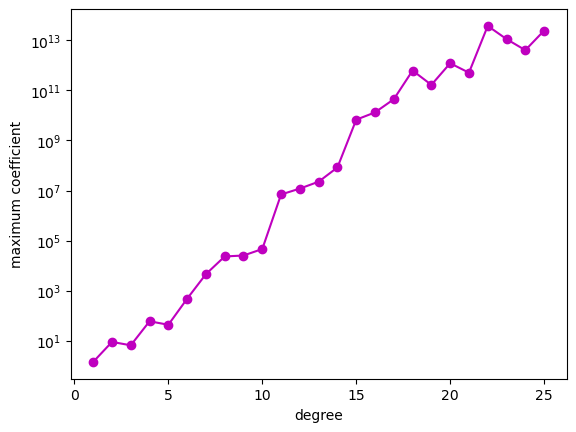

In [11]:
max_degree = 25

regression = lm.LinearRegression()

max_coeffs = np.zeros(max_degree)

degrees = range(1, max_degree + 1)

for degree in degrees:

    # regression
    transform = PolynomialFeatures(degree=degree).fit_transform
    regression.fit(transform(X_train), y_train)

    # maximum coefficient
    max_coeffs[degree - 1] = np.max(np.abs(regression.coef_))
    
# plot errors
fig, ax = plt.subplots()
ax.semilogy(degrees, max_coeffs, '-om',)
ax.set_xlabel('degree')
ax.set_ylabel('maximum coefficient')
plt.show()

In linear regression and most other method one minimizes a loss function expressing the distance between the hypothesis $f_{\mathrm{approx}}$ and the targets in the training data:
\begin{equation*}
\frac{1}{n}\,\sum_{l=1}^n\bigl(f_{\mathrm{approx}}(x_l)-y_l\bigr)^2\to\min_{a_1,\ldots,a_\mu},
\end{equation*}
where $a_1,\ldots,a_\mu$ are the parameters of the model.
If we add the squares of the parameters to this function, then we not only force the hypothesis to be close to the data, but we also ensure that the parameters cannot become too large. As we mentioned above, large parameters correlate with overfitting. Modifying a minimization problem in this way is known as *regularization*.

To control the trade-off between data fitting and regularization, we introduce a *regularization parameter* $\alpha\geq 0$:
\begin{equation*}
\frac{1}{n}\,\sum_{l=1}^n\bigl(f_{\mathrm{approx}}(x_l)-y_l\bigr)^2
+\alpha\,\frac{1}{\mu}\,\sum_{\kappa=1}^\mu a_\kappa^2\to\min_{a_1,\ldots,a_\mu}.
\end{equation*}
The regularization parameter $\alpha$ is an additional hyperparameter of the model.

There are several other penalty terms, which will be discussed below. Adding squares of the model parameters is the simplest version from the view of computational efficiency. Linear regression regularized this way is also known as *Ridge regression*.

Scikit-Learn implements Ridge regression in the `linear_model` module: [`Ridge`](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.Ridge.html).

In [12]:
degree = 20    # degree for polynomial regression
alpha = 1e-5    # regularization parameter

# regression
regression = lm.Ridge(alpha=alpha)
transform = PolynomialFeatures(degree=degree).fit_transform
regression.fit(transform(X), y)

# get hypothesis for plotting
y_reg = regression.predict(transform(x.reshape(-1, 1)))

# plot truth, data, hypothesis
fig, ax = plt.subplots()
ax.plot(x, truth(x), '-b', label='truth')
ax.plot(X.reshape(-1), y, 'or', markersize=3, label='data')
ax.plot(x, y_reg, '-g', label='model')
ax.legend()
plt.show()

In our exmaple we know the underlying truth. Thus, we may compare predictions from the regularized model to the truth for different regularization parameters.

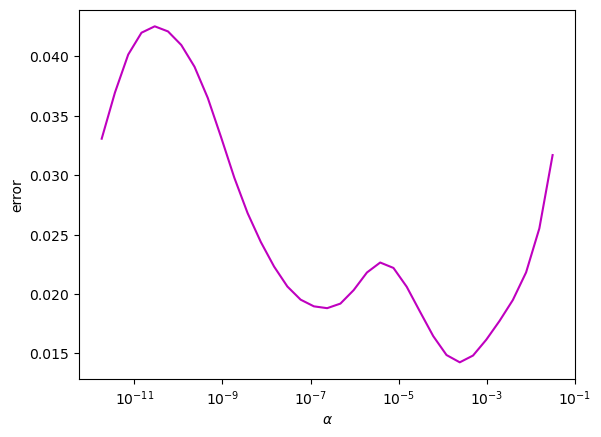

In [13]:
degree = 20    # degree for polynomial regression
alphas = [2 ** (-k) for k in range(5, 40)]    # regularization parameters

errors = np.zeros(len(alphas))

for idx, alpha in enumerate(alphas):

    # regression
    regression = lm.Ridge(alpha=alpha)
    transform = PolynomialFeatures(degree=degree).fit_transform
    regression.fit(transform(X_train), y_train)

    # get mean squared error for equispaced grid (same as for plotting)
    y_reg = regression.predict(transform(x.reshape(-1, 1)))
    y_true = truth(x)
    errors[idx] = metrics.mean_squared_error(y_reg, y_true)

# plot errors
fig, ax = plt.subplots()
ax.semilogx(alphas, errors, '-m')
ax.set_xlabel('$\\alpha$')
ax.set_ylabel('error')
plt.show()

For $\alpha$ close to zero overfitting leads to large errors. For large $\alpha$ model parameters are close to zero, which leads to very bad data fitting and, thus, to large errors, too (*overregularization*). Between both ends there is a local minimum, yielding the optimal $\alpha$.

In practice we do not know the truth. But analogously to detecting overfitting we may find values for $\alpha$, where overfitting vanishes. We simply have to start with very small $\alpha$ leading to overfitting. Then we increase $\alpha$ until training and validation data yield similar mean squared errors when compared to the hypothesis.

In [15]:
degree = 20    # degree for polynomial regression
alphas = [2 ** (-k) for k in range(5, 40)]    # regularization parameters

train_errors = np.zeros(len(alphas))
val_errors = np.zeros(len(alphas))

for idx, alpha in enumerate(alphas):

    # regression
    regression = lm.Ridge(alpha=alpha)
    transform = PolynomialFeatures(degree=degree).fit_transform
    regression.fit(transform(X_train), y_train)

    # predictions on subsets
    y_train_pred = regression.predict(transform(X_train))
    y_val_pred = regression.predict(transform(X_val))
    
    # errors
    train_errors[idx] = metrics.mean_squared_error(y_train_pred, y_train)
    val_errors[idx] = metrics.mean_squared_error(y_val_pred, y_val)

# plot errors
fig, (ax_left, ax_right) = plt.subplots(1, 2, figsize=(12, 4))
ax_left.semilogx(alphas, train_errors, '-r', label='errors on training set')
ax_left.semilogx(alphas, val_errors, '-y', label='errors on validation set')
ax_left.set_xlabel('$\\alpha$')
ax_left.set_ylabel('mean squared error')
ax_left.legend()
ax_right.semilogx(alphas, val_errors / train_errors, '-m')
ax_right.set_xlabel('$\\alpha$')
ax_right.set_ylabel('ratio of mean squared errors')
plt.show()

# print errors
print('  training       validation')
print(np.stack((train_errors, val_errors), axis=1))

  training       validation
[[0.07326089 0.10832048]
 [0.07075901 0.10408418]
 [0.06954605 0.10167556]
 [0.06871829 0.10026634]
 [0.06773215 0.09926158]
 [0.06630425 0.09848887]
 [0.06443948 0.09830744]
 [0.06251508 0.09948163]
 [0.06100575 0.10238347]
 [0.06000687 0.10645098]
 [0.05927804 0.1108613 ]
 [0.05859948 0.11495806]
 [0.05785644 0.11780122]
 [0.0569407  0.11823884]
 [0.05579468 0.11589774]
 [0.05456294 0.11190603]
 [0.05352215 0.10822899]
 [0.05277435 0.10602967]
 [0.05218768 0.10528655]
 [0.05163829 0.10579957]
 [0.05114153 0.10762232]
 [0.0507495  0.11063545]
 [0.05043095 0.11450807]
 [0.05011846 0.11923569]
 [0.04980821 0.12506099]
 [0.0495608  0.13166127]
 [0.04941321 0.1379058 ]
 [0.0493391  0.14279624]
 [0.04929224 0.14614947]
 [0.04923822 0.14819351]
 [0.04915017 0.14892117]
 [0.04899594 0.1478916 ]
 [0.04873589 0.14449768]
 [0.04834478 0.13855119]
 [0.04785498 0.13111712]]


Note that this way only values for $\alpha$ leading to overfitting can be detected. But overregularization does not lead to large differences in the errors. Thus overregularization is indistinguishable from good fitting if only errors on training and validation sets are compared.

## Example: Scaling is Important

Consider regularized linear regression (Ridge regression) with two features. This example is just for illustration; never use regularization if your model has only three parameters! Values of feature 1 are between 0 and 1, values of feature 2 are between 1900 and 2100. With
\begin{equation*}
f_{\mathrm{approx}}(x)=a_0+a_1\,x^{(1)}+a_2\,x^{(2)}
\end{equation*}
we have to solve
\begin{equation*}
\frac{1}{n}\,\sum_{l=1}^n\bigl(f_{\mathrm{approx}}(x_l)-y_l\bigr)^2+\alpha\,\frac{1}{3}\,\bigl(a_0^2+a_1^2+a_2^2\bigr)\to\min_{a_0,a_1,a_2},
\end{equation*}
where $(x_1,y_1),\ldots,(x_n,y_n)$ are the training samples and $\alpha$ is the regularization parameter.

If the target variable $y$ is small, say between -1 and 1, then $a_1$ is likely to take a value between -1 and 1, too. But $a_2$ will be much smaller than 1, say between $-\frac{1}{2000}$ and $\frac{1}{2000}$.
Thus, $a_2$ has almost no influence on the penalty term for regularization. The result is, that feature 1 is suppressed by regularization ($a_1$ much smaller than without regularization) and feature 2 is left untouched ($a_2$ of same magnitude as without regularization).

Such imbalance should be avoided. Of course, one feature might be more relevant for explaining the data than other features. But here the imbalance stems from penalizing all features with the same factor $\alpha$ regardless of their range of values.

## Other Regularization Methods

Next to adding squares of the model parameters there are several other choices for the penalty. Here we only consider two of them.
* *LASSO* (Least Absolute Shrinkage and Selection Operator):
\begin{equation*}
\alpha\,\frac{1}{\mu}\,\sum_{\kappa=1}^\mu|a_\kappa|.
\end{equation*}
* *Elastic Net*:
\begin{equation*}
\alpha\,\frac{1}{\mu}\,\left(\beta\,\sum_{\kappa=1}^\mu|a_\kappa|+(1-\beta)\,\sum_{\kappa=1}^\mu a_\kappa^2\right),
\end{equation*}
where $\beta\in[0,1]$ is a further hyperparameter, also known as mixing parameter.
Solving minimization problems with LASSO penalty is numerically more challenging, but leads to hypotheses with only very few non-zero parameters (this is not obvious, but can rigorously be proven).
Elastic Net penalties are a mixture of the standard penalty and the LASSO penalty, yielding numerically more tractable minimization problems, but still enforcing many parameters to be zero.

Regularized linear regression with LASSO and Elastic Net penalties is available in Scikit-Learn's `linear_model` module: [`Lasso`](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.Lasso.html), [`ElasticNet`](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.ElasticNet.html).